In [1]:
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-10-06 21:36:55.682993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 21:36:55.683025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 21:36:55.684323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 21:36:55.693465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 21:36:56.844895: W tensorflow/comp

In [2]:
bands = ['reconstructed_signal', 'saa1', 'saa2', 'saa3', 'saa4', 'saa5']
bandspred = ['reconstructed_signal', 'saa1', 'saa2', 'saa3', 'saa4', 'saa5', 'pred']

featuresDict = {
    'reconstructed_signal': tf.io.VarLenFeature(dtype=tf.float32),
    'saa1': tf.io.VarLenFeature(dtype=tf.float32),
    'saa2': tf.io.VarLenFeature(dtype=tf.float32),
    'saa3': tf.io.VarLenFeature(dtype=tf.float32),
    'saa4': tf.io.VarLenFeature(dtype=tf.float32),
    'saa5': tf.io.VarLenFeature(dtype=tf.float32),
    'pred': tf.io.VarLenFeature(dtype=tf.float32),
    'name': tf.io.VarLenFeature(dtype=tf.string),
}

# Decoding TFRecord file based in feacture dictionary
def parse_data(example_proto):
    
    return tf.io.parse_single_example(example_proto, featuresDict)

def parse_shape(example_parsed):
    for fea in bandspred:
        example_parsed[fea] = tf.sparse.to_dense(example_parsed[fea])
    
    example_parsed['name'] = tf.sparse.to_dense(example_parsed['name'])
    return example_parsed

def toInputOutput(inputs):
    inputsList = [inputs.get(key) for key in bands]
    stacked = tf.stack(inputsList) # tensor with shape 6, 500
    stacked = tf.transpose(stacked, perm=[1, 0]) # shape (500, 6), 6 signals with 500 samples
    pred = inputs.get('pred')

    return stacked, pred

def toInputOutputName(inputs):
    inputsList = [inputs.get(key) for key in bands]
    stacked = tf.stack(inputsList) # tensor with shape 6, 500
    stacked = tf.transpose(stacked, perm=[1, 0]) # shape (500, 6), 6 signals with 500 samples
    pred = inputs.get('pred')
    name = inputs.get('name')

    return stacked, pred, name

def data_augmentation(signal, pred, noisy = True):
    
    if noisy == True:
        if tf.random.uniform(()) > 0.0:
            std = random.uniform(0.001, 0.005)
            gnoise = tf.random.normal(shape=tf.shape(signal), mean=0.0, stddev=std, dtype=tf.float32)
            signal = tf.add(signal, gnoise)

    return signal, pred

def ReadDataset(tfrecord_path):

    return tf.data.TFRecordDataset(tfrecord_path)\
                .map(parse_data)\
                .map(parse_shape)\
                .map(toInputOutput)\
                .map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

def ReadDatasetTest(tfrecord_path):

    return tf.data.TFRecordDataset(tfrecord_path)\
                .map(parse_data)\
                .map(parse_shape)\
                .map(toInputOutput, num_parallel_calls=tf.data.AUTOTUNE)

In [3]:
# Reading Datset
dataset = ReadDataset('./data/lunar/train_ds.tfrecords')

# Converting tf object to np arrays, to separate in tran and val
signals = []
labels = []

for signal, label in dataset:
    signals.append(signal.numpy())
    labels.append(label.numpy())

signals = np.array(signals)
labels = np.array(labels).flatten()


2024-10-06 21:36:58.978066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3025 MB memory:  -> device: 0, name: Quadro P2000, pci bus id: 0000:21:00.0, compute capability: 6.1


In [4]:
# Split dataset and shuffle
X_train, X_val, y_train, y_val = train_test_split(signals, labels, test_size=0.2, random_state=42)

In [5]:
print(X_train.shape)

(48000, 500, 6)


In [6]:
# Creating model based en CNN1D and BiLSTM, widely used in temporal series
def create_model(input_shape):
    model = tf.keras.Sequential()

    # CNN 1D layer
    model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))

    # Ajustar el tamaño del kernel en la segunda capa
    model.add(tf.keras.layers.Conv1D(128, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))

    # Double BiLSTM layer
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))

    # Dense layers
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(32, activation='relu'))

    # Dense and final layer to predict between -1 and 1, where -1 mean no seisic in this window, and [0 - 1] must be multiplied by 499, to determine the location of the event in the window
    model.add(tf.keras.layers.Dense(1, activation='tanh'))

    return model

In [7]:
# Creating model to accepts an input with shape (500, 6)
model = create_model((500, 6))

# Compiling the model with mse as loss function and mae as metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

2024-10-06 21:37:17.336651: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 64)           1216      
                                                                 
 batch_normalization (Batch  (None, 500, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 128)          16512     
                                                                 
 batch_normalization_1 (Bat  (None, 500, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 500, 128)          0

In [9]:
# Training model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50


2024-10-06 21:37:25.102024: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-10-06 21:37:25.241336: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-06 21:37:27.000468: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f472c006270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-06 21:37:27.000507: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-10-06 21:37:27.009416: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728268647.163894  622264 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - 150s 94ms/step - loss: 0.5069 - mae: 0.6521 - val_loss: 0.5023 - val_mae: 0.6643
Epoch 2/50
1500/1500 [==============================] - 138s 92ms/step - loss: 0.4932 - mae: 0.6390 - val_loss: 0.5582 - val_mae: 0.6433
Epoch 3/50
1500/1500 [==============================] - 137s 92ms/step - loss: 0.4862 - mae: 0.6313 - val_loss: 0.4977 - val_mae: 0.6143
Epoch 4/50
1500/1500 [==============================] - 135s 90ms/step - loss: 0.4761 - mae: 0.6176 - val_loss: 0.4761 - val_mae: 0.6451
Epoch 5/50
1500/1500 [==============================] - 135s 90ms/step - loss: 0.4643 - mae: 0.6026 - val_loss: 0.5097 - val_mae: 0.6477
Epoch 6/50
1500/1500 [==============================] - 134s 89ms/step - loss: 0.4514 - mae: 0.5861 - val_loss: 0.4481 - val_mae: 0.5892
Epoch 7/50
1500/1500 [==============================] - 134s 90ms/step - loss: 0.4333 - mae: 0.5616 - val_loss: 0.4447 - val_mae: 0.5619
Epoch 8/50
1500/1500 [==============================

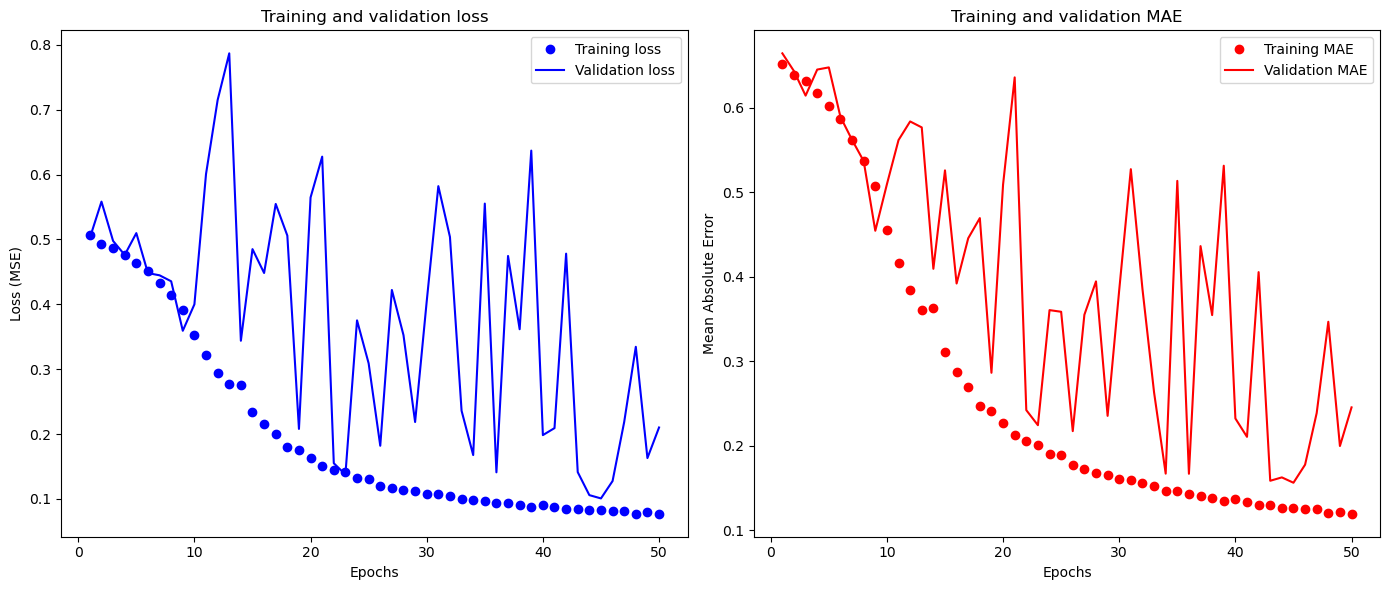

In [10]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mae_values, 'ro', label='Training MAE')
plt.plot(epochs, val_mae_values, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()